In [ ]:
from pathlib import Path
from typing import Tuple, Optional, Dict, List, Union, Callable, Iterable, Set

In [ ]:
!pip install progressbar2

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
from fastcore.script import *
import numpy as np
from shutil import copy
import os
import random
import time
import progressbar
from progressbar import FormatLabel

In [ ]:
def glob_suffixes(root_path: Path, suffixes: Union[List[str], str]) -> List[Path]:
    if isinstance(suffixes, str):
        suffixes = [suffixes]
    return sorted([f for f in root_path.glob("**/*") if file_suffix_in(f, suffixes)])

In [ ]:
# for debugging

from traceback_with_variables import activate_in_ipython_by_import
from PIL import Image
from tempfile import TemporaryDirectory
from shutil import copytree

In [ ]:
dropbox_path = Path("/tf/airt/data/testing/raw")

In [ ]:
@call_parse
def get_suffixes(
    path: Param("input directory containing images", Path),
    verbose: Param("", bool) = True,
) -> Set[str]:
    """Returns all unique suffixes"""
    path = Path(path)
    p = path.glob("**/*")
    files = [x.suffix for x in p if x.is_file()]
    if verbose:
        print(list(set(x.lower() for x in files)))
    return set(x.lower() for x in files)

In [ ]:
actual = get_suffixes(dropbox_path)

expected = set(['.jpg', '.xmp', '.tif', '.cr2', '.mov', '.info'])

assert actual == expected, f"{actual} != {expected}"

['.cr2', '.xmp', '.tif', '.jpg', '.info', '.mov']


In [ ]:
def get_rand_file_with_suff(
    path: Path, suffix: str, case_insensitive: bool = True
) -> Path:
    """Returns a random file that has a suffix equal to the variable suff"""
    if case_insensitive:
        p = [p for p in path.glob(f"**/*") if p.suffix.lower() == suffix.lower()]
    else:
        p = path.glob(f"**/*{suffix}")
    files = [x for x in p if x.is_file()]
    return random.choice(files)

In [ ]:
actual = get_rand_file_with_suff(dropbox_path, ".JpG")
display(actual)

assert isinstance(actual, Path)
assert actual.exists()
assert actual.is_file()
assert actual.suffix.lower() == ".jpg"

Path('/tf/airt/data/testing/raw/Grga_18062007_1_1_001-1.jpg')

In [ ]:
def get_one_image_for_each_suffix(path: Path) -> List[Path]:
    """Returns one random image for each suffix"""
    return [
        get_rand_file_with_suff(path, suffix)
        for suffix in get_suffixes(path, verbose=False)
    ]

In [ ]:
display(get_one_image_for_each_suffix(dropbox_path))
assert len(get_suffixes(dropbox_path, verbose=False)) == len(
    get_one_image_for_each_suffix(dropbox_path)
)

[Path('/tf/airt/data/testing/raw/140830_47_1_1113.CR2'),
 Path('/tf/airt/data/testing/raw/070828_20_1_0040.JPG.xmp'),
 Path('/tf/airt/data/testing/raw/Grga_18062007_1_1_001-1.tif'),
 Path('/tf/airt/data/testing/raw/070728_9_1_0012.JPG'),
 Path('/tf/airt/data/testing/raw/ZbThumbnail.info'),
 Path('/tf/airt/data/testing/raw/MVI_3536.MOV')]

In [ ]:
def create_sample_test_dir_if_needed(
    dst: Path = Path("../../data/testing/raw"),
) -> List[Path]:
    """Creates samples for a test set"""
    dst.mkdir(parents=True, exist_ok=True)
    if len(list(dst.glob("*"))) == 0:
        files = get_one_image_for_each_suffix(dropbox_path)
        for f in files:
            copy(f, dst)
    return list(dst.glob("*"))

In [ ]:
!pwd

/tf/airt/notebooks/utils


In [ ]:
expected_path = Path("../../data/testing/raw")
actual = create_sample_test_dir_if_needed()
assert expected_path.exists()
assert len(actual) > 0
actual

[Path('../../data/testing/raw/070828_20_1_0040.JPG.xmp'),
 Path('../../data/testing/raw/ZbThumbnail.info'),
 Path('../../data/testing/raw/Grga_18062007_1_1_001-1.jpg'),
 Path('../../data/testing/raw/070728_9_1_0012.JPG'),
 Path('../../data/testing/raw/140830_47_1_1113.CR2'),
 Path('../../data/testing/raw/Grga_18062007_1_1_001-1.tif'),
 Path('../../data/testing/raw/070728_10_1_0012.JPG'),
 Path('../../data/testing/raw/MVI_3536.MOV'),
 Path('../../data/testing/raw/.ipynb_checkpoints')]

In [ ]:
def convert_image_to_jpg_darktable(
    img_path: Path,
    *,
    suffixes_to_delete: List[str] = [".mov", ".mp4"],
    remove_src: bool = False,
    update_msg_fn: Callable[[str], None] = print,
) -> str:
    update_msg_fn(f"Processing {img_path}")
    """Converts image whose suffix is not in the skip_suffixes list, if remove_src = True then deletes the input image"""
    if img_path.suffix.lower() != ".jpg":
        dst = img_path.parent / (img_path.stem + ".jpg")
        if img_path.suffix.lower() in suffixes_to_delete:
            if remove_src:
                retmsg = f"Removed {img_path} because {img_path.suffix.lower()} is in {suffixes_to_delete}"
                img_path.unlink()
            else:
                retmsg = f"Not removing {img_path} although {img_path.suffix.lower()} is in {suffixes_to_delete}"
            return None, retmsg
        if dst.exists() and remove_src:
            img_path.unlink()
            retmsg = f"Removed {img_path} because {dst} exists."
            return dst, retmsg
        system_error = os.system(f"darktable-cli {img_path} {dst}")
        if system_error != 0:
            retmsg = f"Converted error {system_error}, image path {img_path}."
            return img_path, retmsg
        if remove_src:
            img_path.unlink()
        retmsg = f"Converted {img_path} to {dst}."
        return dst, retmsg
    else:
        retmsg = f"Skiped path {img_path} because it is already a JPEG."
        return img_path, retmsg

NEW tif /tmp/tmp0xptx0nk/raw/Grga_18062007_1_1_001-1_copy.tif
Processing /tmp/tmp0xptx0nk/raw/070828_20_1_0040.JPG.xmp
Converted error 256, image path /tmp/tmp0xptx0nk/raw/070828_20_1_0040.JPG.xmp.
Processing /tmp/tmp0xptx0nk/raw/Grga_18062007_1_1_001-1_copy.tif
Converted /tmp/tmp0xptx0nk/raw/Grga_18062007_1_1_001-1_copy.tif to /tmp/tmp0xptx0nk/raw/Grga_18062007_1_1_001-1_copy.jpg.
Processing /tmp/tmp0xptx0nk/raw/ZbThumbnail.info
Converted error 256, image path /tmp/tmp0xptx0nk/raw/ZbThumbnail.info.
Processing /tmp/tmp0xptx0nk/raw/Grga_18062007_1_1_001-1.jpg
Skiped path /tmp/tmp0xptx0nk/raw/Grga_18062007_1_1_001-1.jpg because it is already a JPEG.
Processing /tmp/tmp0xptx0nk/raw/070728_9_1_0012.JPG
Skiped path /tmp/tmp0xptx0nk/raw/070728_9_1_0012.JPG because it is already a JPEG.
Processing /tmp/tmp0xptx0nk/raw/140830_47_1_1113.CR2
Converted /tmp/tmp0xptx0nk/raw/140830_47_1_1113.CR2 to /tmp/tmp0xptx0nk/raw/140830_47_1_1113.jpg.
Processing /tmp/tmp0xptx0nk/raw/Grga_18062007_1_1_001-1.ti

[Path('/tmp/tmp0xptx0nk/raw/.ipynb_checkpoints'),
 Path('/tmp/tmp0xptx0nk/raw/070728_10_1_0012.JPG'),
 Path('/tmp/tmp0xptx0nk/raw/070728_9_1_0012.JPG'),
 Path('/tmp/tmp0xptx0nk/raw/070828_20_1_0040.JPG.xmp'),
 Path('/tmp/tmp0xptx0nk/raw/140830_47_1_1113.CR2'),
 Path('/tmp/tmp0xptx0nk/raw/Grga_18062007_1_1_001-1.jpg'),
 Path('/tmp/tmp0xptx0nk/raw/Grga_18062007_1_1_001-1.tif'),
 Path('/tmp/tmp0xptx0nk/raw/Grga_18062007_1_1_001-1_copy.tif'),
 Path('/tmp/tmp0xptx0nk/raw/MVI_3536.MOV'),
 Path('/tmp/tmp0xptx0nk/raw/ZbThumbnail.info')]

[Path('/tmp/tmp0xptx0nk/raw/.ipynb_checkpoints'),
 Path('/tmp/tmp0xptx0nk/raw/070728_10_1_0012.JPG'),
 Path('/tmp/tmp0xptx0nk/raw/070728_9_1_0012.JPG'),
 Path('/tmp/tmp0xptx0nk/raw/070828_20_1_0040.JPG.xmp'),
 Path('/tmp/tmp0xptx0nk/raw/140830_47_1_1113.jpg'),
 Path('/tmp/tmp0xptx0nk/raw/Grga_18062007_1_1_001-1.jpg'),
 Path('/tmp/tmp0xptx0nk/raw/Grga_18062007_1_1_001-1_copy.jpg'),
 Path('/tmp/tmp0xptx0nk/raw/ZbThumbnail.info')]

/tmp/tmp0xptx0nk/raw/140830_47_1_1113.jpg


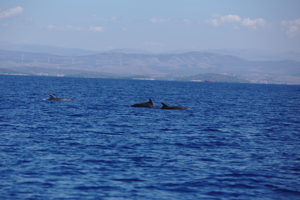

/tmp/tmp0xptx0nk/raw/Grga_18062007_1_1_001-1.jpg


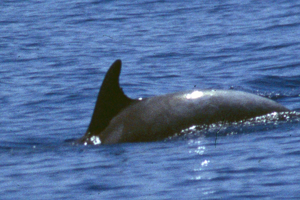

/tmp/tmp0xptx0nk/raw/070728_9_1_0012.JPG


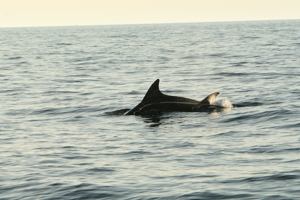

/tmp/tmp0xptx0nk/raw/070728_10_1_0012.JPG


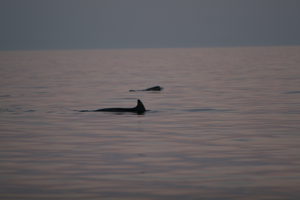

/tmp/tmp0xptx0nk/raw/Grga_18062007_1_1_001-1_copy.jpg


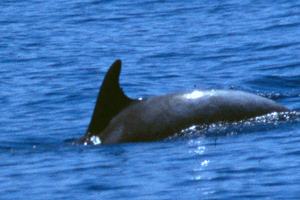

In [ ]:
with TemporaryDirectory() as src_dir:
    src_dir = Path(src_dir) / "raw"
    copytree("../../data/testing/raw/", src_dir)
    tif_path = [x for x in src_dir.glob("*.tif")][0]
    new_tif = tif_path.parent / (tif_path.stem + "_copy" + tif_path.suffix)
    print(f"NEW tif {new_tif}")
    copy(tif_path, new_tif)
    before_files = [x for x in src_dir.glob("*")]
    jpg_before = [x for x in before_files if x.suffix.lower() == ".jpg"]
    for image_path in src_dir.glob("*"):
        dst, msg = convert_image_to_jpg_darktable(image_path, remove_src=True)
        assert not dst or dst.exists()
        print(msg)
    after_files = [x for x in src_dir.glob("*")]
    assert len(before_files) == len(after_files) + 2
    display(sorted(before_files))
    display(sorted(after_files))
    jpg_after = [x for x in after_files if x.suffix.lower() == ".jpg"]
    assert len(jpg_after) == len(jpg_before) + 2

    for img_after in jpg_after:
        if img_after.suffix.lower() == ".jpg":
            print(img_after)
            display(Image.open(img_after).resize((300, 200)))

In [ ]:
@call_parse
def convert_files_with_darktable(
    root_path: Param("input directory containing images to convert", Path),
    remove_src: Param("input True if you want to delete the images ", bool) = True,
):
    """Calls the convert_image_to_jpg() function on all images in the path"""
    root_path = Path(root_path)
    widgets = [
        FormatLabel(""),
        " [",
        progressbar.Timer(),
        "] ",
        progressbar.Bar(),
        progressbar.Percentage("%(percentage)5.2f%%"),
        " (",
        progressbar.AdaptiveETA(),
        ") ",
    ]
    files = sorted([x for x in root_path.glob("**/*") if x.is_file()])
    n_files = len(files)

    def update_msg(msg):
        widgets[0] = FormatLabel(f"[{i:4d}/{n_files}] {msg}")

    log = []
    with progressbar.ProgressBar(max_value=len(files), widgets=widgets) as bar:
        for i, src in enumerate(files):
            _, msg = convert_image_to_jpg_darktable(
                src, remove_src=remove_src, update_msg_fn=update_msg
            )
            log.append(msg)
            bar.update(i)
    print(f"Conversion completed {len(files)}/{len(files)}")

    for msg in log:
        print(msg)

In [ ]:
with TemporaryDirectory() as src_dir:
    src_dir = Path(src_dir) / "raw"
    copytree("../../data/testing/raw/", src_dir)
    copytree("../../data/testing/raw/", src_dir / "jedan")
    copytree("../../data/testing/raw/", src_dir / "jedan" / "dva")
    copytree("../../data/testing/raw/", src_dir / "tri")
    copytree("../../data/testing/raw/", src_dir / "tri" / "cetiri")
    files_before = list(src_dir.glob("**/*"))

    # the main thing
    convert_files_with_darktable(src_dir, remove_src=True)

    files_after = list(src_dir.glob("**/*"))

    assert (
        len(files_before) == len(files_after) + 10
    ), f"len({files_before}) != len({files_after})"

[  39/40] Processing /tmp/tmp0r0lyr9h/raw/tri/cetiri/ZbThumbnail.info [Elapsed Time: 0:00:09] ||100.00% (Time:  0:00:09) 1) 01) 


Conversion completed 40/40
Skiped path /tmp/tmp0r0lyr9h/raw/070728_10_1_0012.JPG because it is already a JPEG.
Skiped path /tmp/tmp0r0lyr9h/raw/070728_9_1_0012.JPG because it is already a JPEG.
Converted error 256, image path /tmp/tmp0r0lyr9h/raw/070828_20_1_0040.JPG.xmp.
Converted /tmp/tmp0r0lyr9h/raw/140830_47_1_1113.CR2 to /tmp/tmp0r0lyr9h/raw/140830_47_1_1113.jpg.
Skiped path /tmp/tmp0r0lyr9h/raw/Grga_18062007_1_1_001-1.jpg because it is already a JPEG.
Removed /tmp/tmp0r0lyr9h/raw/Grga_18062007_1_1_001-1.tif because /tmp/tmp0r0lyr9h/raw/Grga_18062007_1_1_001-1.jpg exists.
Removed /tmp/tmp0r0lyr9h/raw/MVI_3536.MOV because .mov is in ['.mov', '.mp4']
Converted error 256, image path /tmp/tmp0r0lyr9h/raw/ZbThumbnail.info.
Skiped path /tmp/tmp0r0lyr9h/raw/jedan/070728_10_1_0012.JPG because it is already a JPEG.
Skiped path /tmp/tmp0r0lyr9h/raw/jedan/070728_9_1_0012.JPG because it is already a JPEG.
Converted error 256, image path /tmp/tmp0r0lyr9h/raw/jedan/070828_20_1_0040.JPG.xmp.
Con